<a href="https://colab.research.google.com/github/nguyen084/MATH5671/blob/master/MATH5671_Group005_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Math 5671 Final Project: GDP and Inflation Forecasting**

**Author: Hieu Nguyen**

**Fall 2019 **

![alt text](https://media.licdn.com/dms/image/C5103AQH2Iw3QkQqBEg/profile-displayphoto-shrink_200_200/0?e=1579737600&v=beta&t=Iug-0d6Wl3Y7pUww8BqR8J4B3Zb3gbAerDxFOrllxlc)

Hieu Nguyen is a Computer Science Ph.D. student at UCONN. His focus is in forecasting and machine learning methods. Prior attending UCONN, he obtained BA and MA in Mathematics with a minor in Economics, and he had done various research projects related to steganography, price optimization, economic analysis, and computer vision.

# 0.Problem Description
Macroeconomics is the study of the structure and the behavior of the economy and of the economy's core variables; macro-messaging is the use of the variables by policy makers to determine what actions to take; macroeconomic policy is the government's use of macroeconomic policy to boost the economy. Macroeconomics involves knowledge about monetary and fiscal policy, trade and finance, bank lending, corporate finance, and international markets.

Gross Domestic Product (GDP) indicates the goods and services produced in the United States by labor and property, as well as capital goods and inventories. Inflation rate is the ratio of the price of goods and services received by the consumers over time. As long as the inflation rate stays within a certain range, the economy is generally in a healthy condition. These two indicators plays an important role in determining the direction of the economy. Thus, by predicting
GDP and Inflation Rate, we would able to have an advantage edge in knowing where the market is heading. 

Therefore, in this project, we would like to conduct experiments and forecast GDP and inflation rate using various Machine Learning models from Linear Regression, Support Vector Machine and Artificial Neural Network.

# I.GDP Growth Rate prediction

## 1)Data
We get our data from the Federal Reserve Economic Data Server or the National Bureau of Economic Research. This is also the repository of the historical data that we use to collect the indicator and analyze them. https://fred.stlouisfed.org/

**Using quandl API, we retrive the the desired the data and as describe below:**
*   A191RO1Q156NBEA: GDP Growthrate
*   CPIAUCSL: Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (Data is release around the 2nd week)
*   GS10: 10-Year Treasury Constant Maturity Rate (Data is updated first day of next month)
*   FEDFUNDS: Effective Federal Funds Rate
*   UNRATE: Unemployment Rate
*   TB3MS: 3-Month Treasury Bill: Secondary Market Rate
*   PAYEMS: All Employees, Total Nonfarm
*   INDPRO: Industrial Production Index
*   GS1: 1-Year Treasury Constant Maturity Rate
*   HOUST: Housing Starts: Total: New Privately Owned Housing Units Started 
*   GS5: 5-Year Treasury Constant Maturity Rate
*   BAA10YM: Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
*   MANEMP: All Employees, Manufacturing
*   MPRIME: Bank Prime Loan Rate

All of the feature are monthly, except GDP growthrate which is release quarterly.

In [0]:
# First is to install quandl API in order to get economics data from FRED
!pip install quandl &> /dev/null
import quandl
import pandas as pd
quandl.ApiConfig.api_key = '2_XgYH_MD3-xWKC-4xEi' #To get API, create an account on quandl
GDP = quandl.get("FRED/A191RO1Q156NBEA").rename(columns={'Value':'GDP_growthrate'}) #To get indicator code, go to FRED website
"""
In this project, we are trying forecast GDP. Knowing that the ideal GDP rate is around 2-3%. we will classify as the following:
"""
for index, row in GDP.iterrows():
  if row['GDP_growthrate'] > 2:
    row['GDP_growthrate'] = 1
  else:
    row['GDP_growthrate'] = 0

In [0]:
#Count each class
GDP.groupby(['GDP_growthrate'])[['GDP_growthrate']].count()

,GDP_growthrate
GDP_growthrate,
0.0,82
1.0,205


The groups are unblanced, but due to the fact we have limited data, we will keep the original dataset.

Since GDP is reported quarterly usually 2 months after each period, we use the data of that particular months and attempt to predict the currrent GDP. 
For example: Use data from Jan,Fed,and March to predict GDP of quarter 1.

In [0]:
#Getting the indicators and stored as dataframe
indicator_list = ['CPIAUCSL','GS10','FEDFUNDS','UNRATE','TB3MS','PAYEMS','INDPRO','GS1','HOUST','GS5','BAA10YM','MANEMP','MPRIME']
df = quandl.get("FRED/CPIAUCSL") #Initialize the dataframe
df = df.rename(columns={'Value':'CPIAUCSL'})
for indicator in indicator_list:
    #print(indicator)
    indi = quandl.get("FRED/{}".format(indicator)) #Third month
    indi2 = indi.shift(1,axis=0) #Second month
    indi3 = indi.shift(2,axis=0) #First month
    indi = indi.rename(columns={'Value':str(indicator)+'_3'})
    indi2 = indi2.rename(columns={'Value':str(indicator)+'_2'})
    indi3 = indi3.rename(columns={'Value':str(indicator)+'_1'})
    df = pd.concat([df,indi],axis = 1, join='inner')
    df = pd.concat([df,indi2],axis = 1, join='inner')
    df = pd.concat([df,indi3],axis = 1, join='inner')
df = df.drop('CPIAUCSL', 1)
df = pd.concat([df,GDP],axis = 1,join='inner') #Then we can add GDP value as the last column
df = df.dropna() #Drop any row that has mising data
df.head(5) #Show the first few value

,CPIAUCSL_3,CPIAUCSL_2,CPIAUCSL_1,GS10_3,GS10_2,GS10_1,FEDFUNDS_3,FEDFUNDS_2,FEDFUNDS_1,UNRATE_3,UNRATE_2,UNRATE_1,TB3MS_3,TB3MS_2,TB3MS_1,PAYEMS_3,PAYEMS_2,PAYEMS_1,INDPRO_3,INDPRO_2,INDPRO_1,GS1_3,GS1_2,GS1_1,HOUST_3,HOUST_2,HOUST_1,GS5_3,GS5_2,GS5_1,BAA10YM_3,BAA10YM_2,BAA10YM_1,MANEMP_3,MANEMP_2,MANEMP_1,MPRIME_3,MPRIME_2,MPRIME_1,GDP_growthrate
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1959-04-01,28.98,28.97,29.00,4.12,3.99,3.96,2.96,2.80,2.43,5.2,5.6,5.9,2.95,2.80,2.70,53321.0,53014.0,52688.0,23.8989,23.4004,23.0681,3.72,3.61,3.54,1590.0,1620.0,1667.0,4.12,3.99,3.96,0.74,0.86,0.93,15385.0,15259.0,15115.0,4.0,4.0,4.00,1.0
1959-07-01,29.15,29.11,29.04,4.40,4.34,4.31,3.47,3.39,2.90,5.1,5.0,5.1,3.20,3.21,2.84,53804.0,53681.0,53550.0,23.7050,24.2866,24.2589,4.39,4.07,3.96,1547.0,1503.0,1498.0,4.58,4.50,4.35,0.68,0.70,0.65,15623.0,15554.0,15487.0,4.5,4.5,4.23,1.0
1959-10-01,29.35,29.25,29.18,4.53,4.68,4.43,3.98,3.76,3.50,5.7,5.5,5.2,4.05,4.04,3.38,53358.0,53428.0,53336.0,22.7081,22.8743,22.9019,4.80,5.00,4.42,1355.0,1540.0,1430.0,4.72,4.90,4.57,0.75,0.50,0.66,15158.0,15254.0,15202.0,5.0,5.0,4.50,1.0
1960-01-01,29.37,29.41,29.35,4.72,4.69,4.53,3.99,3.99,4.00,5.2,5.3,5.8,4.35,4.49,4.15,54274.0,54174.0,53634.0,24.8958,24.2589,22.8466,5.03,5.14,4.81,1460.0,1601.0,1416.0,4.92,5.01,4.75,0.62,0.59,0.73,15687.0,15573.0,15300.0,5.0,5.0,5.00,1.0
1960-04-01,29.54,29.41,29.41,4.28,4.25,4.49,3.92,3.84,3.97,5.2,5.4,4.8,3.23,3.31,3.96,54813.0,54454.0,54513.0,24.2589,24.4528,24.6743,4.04,4.02,4.66,1289.0,1109.0,1503.0,4.29,4.31,4.69,0.92,1.00,0.85,15654.0,15707.0,15765.0,5.0,5.0,5.00,1.0


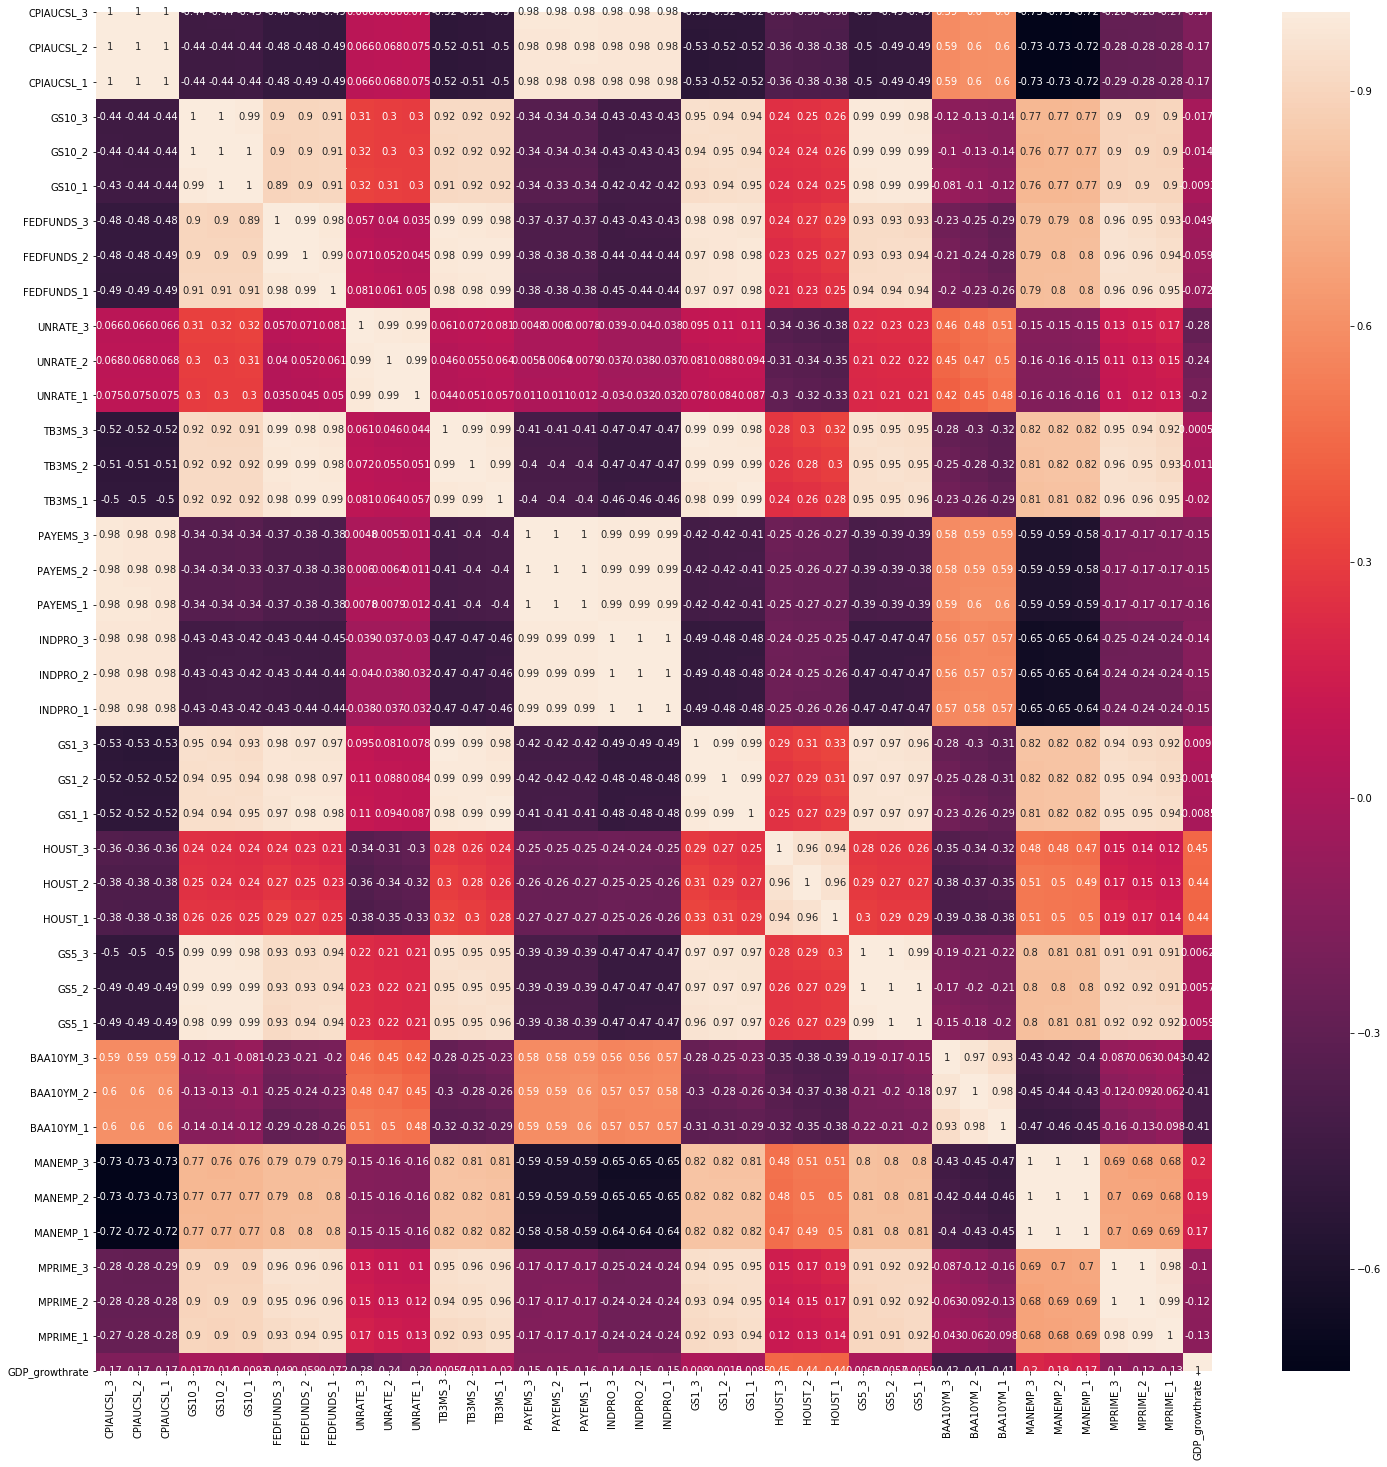

In [0]:
'''
We can visualize using the correlation matrix to get some speculation
'''
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
corr = df.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr,annot = True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

**Correlation Matrix Remark:** From the plot ablove, we can see that inflation, house ownership, unemployment rate, and Moody's Seasoned Baa Corporate Bond Yield has quite a high correlation on GDP. We can try to do some linear regression to see some significant levels.

### Data Preprocessing
Since the features are at different scale, standizing them would help improve the model. To preprocess it, we use the MinMaxScaler from sklearn library. We then split the dataset into training set and testing set. We use 80% of the data for training and validation, and 20% for testing.


In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
min_max_scaler = MinMaxScaler()
x = df[df.columns[:-1]]
y = df[df.columns[-1]].values
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2,shuffle=False)
xtrain = min_max_scaler.fit_transform(xtrain)
xtest = min_max_scaler.transform(xtest)

## 2)Linear Regression
The linear model of GDP is describe as below:
$$GDP = \alpha(GS10) + \beta(FEDFUNDS)+...+\gamma(MPRIME $$

In [0]:
import statsmodels.api as sm
model = sm.OLS(ytrain, xtrain).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.903
Method:                 Least Squares   F-statistic:                              47.33
Date:                Fri, 22 Nov 2019   Prob (F-statistic):                    1.07e-67
Time:                        00:14:37   Log-Likelihood:                         -2.7671
No. Observations:                 193   AIC:                                      83.53
Df Residuals:                     154   BIC:                                      210.8
Df Model:                          39                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            15.5010     14.874      1.042      0.299     -13.882      44.884
x2           -15.5356     22.149     -0.701      0.484     -59.291      28.219
x3             4.8185     14.036      0.343      0.732     -22.910      32.547
x4             0.4276      3.685      0.116      0.908      -6.852       7.707
x5            -3.3675      5.700     -0.591      0.556     -14.627       7.892
x6             2.4525      3.840      0.639      0.524      -5.133      10.038
x7            -2.7363      1.560     -1.755      0.081      -5.817       0.345
x8             3.7304      2.359      1.581      0.116      -0.930       8.391
x9            -4.1459      1.899     -2.183      0.031      -7.897      -0.394
x10           -0.9009      1.086     -0.829      0.408      -3.047       1.245
x11            1.1051      1.463      0.756      0.451      -1.784       3.994
x12           -0.1582      1.274     -0.124      0.901      -2.675       2.358
x13           -3.7267      2.381     -1.565      0.120      -8.431       0.978
x14           -4.0420      3.178     -1.272      0.205     -10.320       2.236
x15            9.7855      2.940      3.329      0.001       3.978      15.593
x16           38.5689     16.995      2.269      0.025       4.995      72.143
x17          -16.1872     26.633     -0.608      0.544     -68.800      36.425
x18          -28.0282     17.877     -1.568      0.119     -63.345       7.288
x19          -11.7948      5.912     -1.995      0.048     -23.473      -0.117
x20            1.3152      7.602      0.173      0.863     -13.702      16.332
x21           11.2536      6.044      1.862      0.065      -0.686      23.193
x22            8.2080      3.656      2.245      0.026       0.987      15.429
x23            2.7168      4.874      0.557      0.578      -6.913      12.346
x24           -7.7759      3.888     -2.000      0.047     -15.457      -0.095
x25            0.2260      0.329      0.686      0.493      -0.424       0.876
x26            0.1589      0.372      0.427      0.670      -0.576       0.894
x27            0.3426      0.312      1.098      0.274      -0.274       0.959
x28           -5.8639      4.516     -1.299      0.196     -14.785       3.057
x29            3.2716      6.265      0.522      0.602      -9.105      15.648
x30            1.5490      4.811      0.322      0.748      -7.956      11.054
x31           -0.5012      0.805     -0.623      0.534      -2.091       1.089
x32            0.5271      1.201      0.439      0.661      -1.846       2.900
x33            0.1421      0.777      0.183      0.855      -1.392       1.676
x34            4.2463      2.630      1.614      0.109      -0.950       9.443
x35           -0.9498      4.391     -0.216      0.829      -

The model is surprisingly fits quite well with a R-squared of high .90. However, there is a chance of multi-colinearity. We, can try to predict the test set and calculate the accuracy.

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
predictions = abs(model.predict(xtest).round())
print(confusion_matrix(ytest, predictions))
print(classification_report(ytest, predictions))
accuracy = str(np.mean((predictions == ytest) * 100))
print('\nTesting Accuracy: ' + accuracy)
print('===============================')

[[ 9 16]
 [ 3 21]]
              precision    recall  f1-score   support

         0.0       0.75      0.36      0.49        25
         1.0       0.57      0.88      0.69        24

    accuracy                           0.61        49
   macro avg       0.66      0.62      0.59        49
weighted avg       0.66      0.61      0.59        49


Testing Accuracy: 61.224489795918366


**Remark:** It was very interesting to see that a simple linear regression model can achive 61% accuracy on predicting the GDP growthrate direction. 

## 3)Support Vector Machine

Support Vector Machine is a machine learning model that estimates the end values of market movements. Unlike trendlines, the ROC method is more practical: it takes predictions into account of individual investors, and also the choice of starting point, so the method can be applied to a wide range of situations. Support Vector Machine is an open-source machine learning and data mining software package. It is built on top of CUDA and uses CUDA by default. Python, NumPy and SciPy are also supported by various extensions, particularly Torch.

Here, we use the classification method with various type of kernel(linear, polonomial, rbf, and sigmoid) then determine which kernel is suitable to model GDP growthrate.

In [0]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
for ker in ['linear','poly','rbf','sigmoid']:
  regressor = SVC(kernel=ker)
  regressor.fit(xtrain,ytrain)
  pred_train = regressor.predict(xtrain)
  pred = regressor.predict(xtest)
  print('Kernel:',ker)
  print(confusion_matrix(ytest, pred))
  print(classification_report(ytest, pred))
  accuracy = str(np.mean((pred == ytest) * 100))
  print('\nTesting Accuracy: ' + accuracy)
  print('===============================')

Kernel: linear
[[25  0]
 [15  9]]
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77        25
         1.0       1.00      0.38      0.55        24

    accuracy                           0.69        49
   macro avg       0.81      0.69      0.66        49
weighted avg       0.81      0.69      0.66        49


Testing Accuracy: 69.38775510204081
Kernel: poly
[[ 0 25]
 [ 0 24]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        25
         1.0       0.49      1.00      0.66        24

    accuracy                           0.49        49
   macro avg       0.24      0.50      0.33        49
weighted avg       0.24      0.49      0.32        49


Testing Accuracy: 48.97959183673469
Kernel: rbf
[[ 0 25]
 [ 0 24]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        25
         1.0       0.49      1.00      0.66        24

    accurac

**SVC Remark:**
Linear kernel perform the best with 69% accuracy while other kernel underperform.

## 4)Decision Tree Classifier
Decision Tree Classifier is a program that can be used to help you determine if a decision tree classification algorithm correctly classified your inputs. We also would like to test out its performance.

In [0]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(xtrain,ytrain)
#Predict the response for test dataset
pred = clf.predict(xtest)
pred_train = clf.predict(xtrain)
print(confusion_matrix(ytest, pred))
print(classification_report(ytest, pred))
accuracy = str(np.mean((pred == ytest) * 100))
print('\nTesting Accuracy: ' + accuracy)
print('===============================')

[[24  1]
 [24  0]]
              precision    recall  f1-score   support

         0.0       0.50      0.96      0.66        25
         1.0       0.00      0.00      0.00        24

    accuracy                           0.49        49
   macro avg       0.25      0.48      0.33        49
weighted avg       0.26      0.49      0.34        49


Testing Accuracy: 48.97959183673469


**Remark** Not a very method for this dataset.

## 5)Fully Connected Feedforward Neural Network
An agent-based feedforward neural network is more complex than a backpropagation neural network, but it can be useful in certain contexts. In particular, the Feedforward Neural Network can be used to (a) build a model of visual perception, and (b) make predictions about patterns, in combination with previous experience and/or neural activity.

After tried out with a few *architectures*, we decide to build a very simple neural net to ensure the model does not overfit our data.

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from keras.optimizers import Adam
from datetime import datetime
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
input_dim = len(xtrain[0])
output_dim = 1
layers = 3

logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10) 
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=logdir)

model = Sequential()
model.add(Dropout(0.2, input_shape=(input_dim,))) # dropout regularization
model.add(Dense(5, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, input_dim=input_dim, activation='relu'))
model.add(Dense(output_dim, activation='sigmoid'))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
print(model.summary())
history = model.fit(xtrain, ytrain, epochs=2000,batch_size=20, verbose=0,validation_split=0.1)
#history = model.fit(xtrain, ytrain, epochs=100, batch_size=20, verbose=0, validation_split=0.2, callbacks=[early_stopping_cb, tensorboard_cb]) # Use this line if want to try Tensorboard

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_7 (Dropout)          (None, 39)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 200       
_________________________________________________________________
dropout_8 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 30        
_________________________________________________________________
dropout_9 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

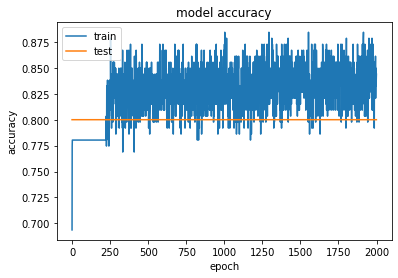

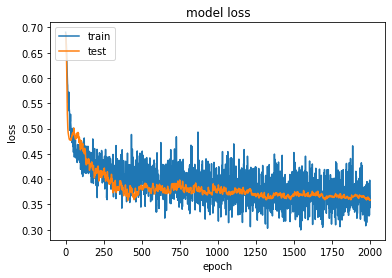

In [0]:
# plotting history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plotting history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(0, 1)

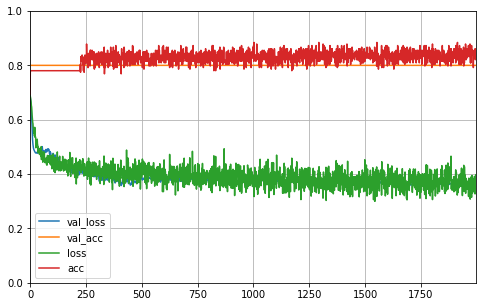

In [0]:
#Another way of viewing loss/accuracy using pandas
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True) 
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()

In [0]:
print('Loss and accurary of test set', model.evaluate(xtest, ytest))
y_test_pred = model.predict(xtest)
from sklearn.metrics import confusion_matrixprint('Loss and accurary of test set', model.evaluate(xtest, ytest))
y_test_pred = model.predict(xtest)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix = confusion_matrix(ytest, y_test_pred.round())
print(confusion_matrix)
print(classification_report(ytest, y_test_pred.round()))
from sklearn.metrics import classification_report
confusion_matrix = confusion_matrix(ytest, y_test_pred.round())
print(confusion_matrix)
print(classification_report(ytest, y_test_pred.round()))

49/49 [==============================] - 0s 153us/step
Loss and accurary of test set [0.6754621729558828, 0.6122449064741329]
[[25  0]
 [19  5]]
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.72        25
         1.0       1.00      0.21      0.34        24

    accuracy                           0.61        49
   macro avg       0.78      0.60      0.53        49
weighted avg       0.78      0.61      0.54        49



**Remark** It is interesting to see that the black-box machine learning model performs quite well in this case. We get a precision of 100% prediction that the GDP would remain normal as 2% growthrate indicates a healthy growth for developed countries.

Model|Linear Regression | SVC_linear | SVC_poly | SVC_rbf |SVC_sigmoid | DecisionTree | NeuralNet
--- | ---| ---| ---| ---| ---| ---| ---
**Test Accurary(%)** | 61.22 | 69.39 | 48.98 | 48.98 | 49.98 | 48.98| 61.22

# II. Inflation Prediction
We would do the exact the same as predicting GDP growthrate, but instead of predicting value quarterly, we predict it monthly.
All of the details are described above, thus we will run the tests all at once and make the conclusion at the end.

## 1.Run above code

In [0]:
IN = quandl.get("FRED/CPIAUCSL",transformation='rdiff').rename(columns={'Value':'Inflation'}) #To get indicator code, go to FRED website
for index, row in IN.iterrows():
  if row['Inflation'] > 0.0025:
    row['Inflation'] = 1
  else:
    row['Inflation'] = 0

In [0]:
#Count each class
IN.groupby(['Inflation'])[['Inflation']].count()

,Inflation
Inflation,
0.0,448
1.0,425


In [0]:
indicator_list = ['GS10','FEDFUNDS','UNRATE','TB3MS','PAYEMS','INDPRO','GS1','HOUST','GS5','BAA10YM','MANEMP','MPRIME']
df = quandl.get("FRED/CPIAUCSL") #Initialize the dataframe
df = df.rename(columns={'Value':'CPIAUCSL'})
for indicator in indicator_list:
    #print(indicator)
    indi = quandl.get("FRED/{}".format(indicator)) #Third month
    indi = indi.rename(columns={'Value':str(indicator)+'_3'})
    df = pd.concat([df,indi],axis = 1, join='inner')
df = df.drop('CPIAUCSL', 1)
df = pd.concat([df,IN],axis = 1,join='inner') #Then we can add GDP value as the last column
df = df.dropna() #Drop any row that has mising data
df.head(10) #Show the first few value

,GS10_3,FEDFUNDS_3,UNRATE_3,TB3MS_3,PAYEMS_3,INDPRO_3,GS1_3,HOUST_3,GS5_3,BAA10YM_3,MANEMP_3,MPRIME_3,Inflation
Date,,,,,,,,,,,,,
1959-01-01,4.02,2.48,6.0,2.82,52478.0,22.6250,3.36,1657.0,4.01,0.85,14998.0,4.00,0.0
1959-02-01,3.96,2.43,5.9,2.70,52688.0,23.0681,3.54,1667.0,3.96,0.93,15115.0,4.00,0.0
1959-03-01,3.99,2.80,5.6,2.80,53014.0,23.4004,3.61,1620.0,3.99,0.86,15259.0,4.00,0.0
1959-04-01,4.12,2.96,5.2,2.95,53321.0,23.8989,3.72,1590.0,4.12,0.74,15385.0,4.00,0.0
1959-05-01,4.31,2.90,5.1,2.84,53550.0,24.2589,3.96,1498.0,4.35,0.65,15487.0,4.23,0.0
1959-06-01,4.34,3.39,5.0,3.21,53681.0,24.2866,4.07,1503.0,4.50,0.70,15554.0,4.50,0.0
1959-07-01,4.40,3.47,5.1,3.20,53804.0,23.7050,4.39,1547.0,4.58,0.68,15623.0,4.50,0.0
1959-08-01,4.43,3.50,5.2,3.38,53336.0,22.9019,4.42,1430.0,4.57,0.66,15202.0,4.50,0.0
1959-09-01,4.68,3.76,5.5,4.04,53428.0,22.8743,5.00,1540.0,4.90,0.50,15254.0,5.00,0.0


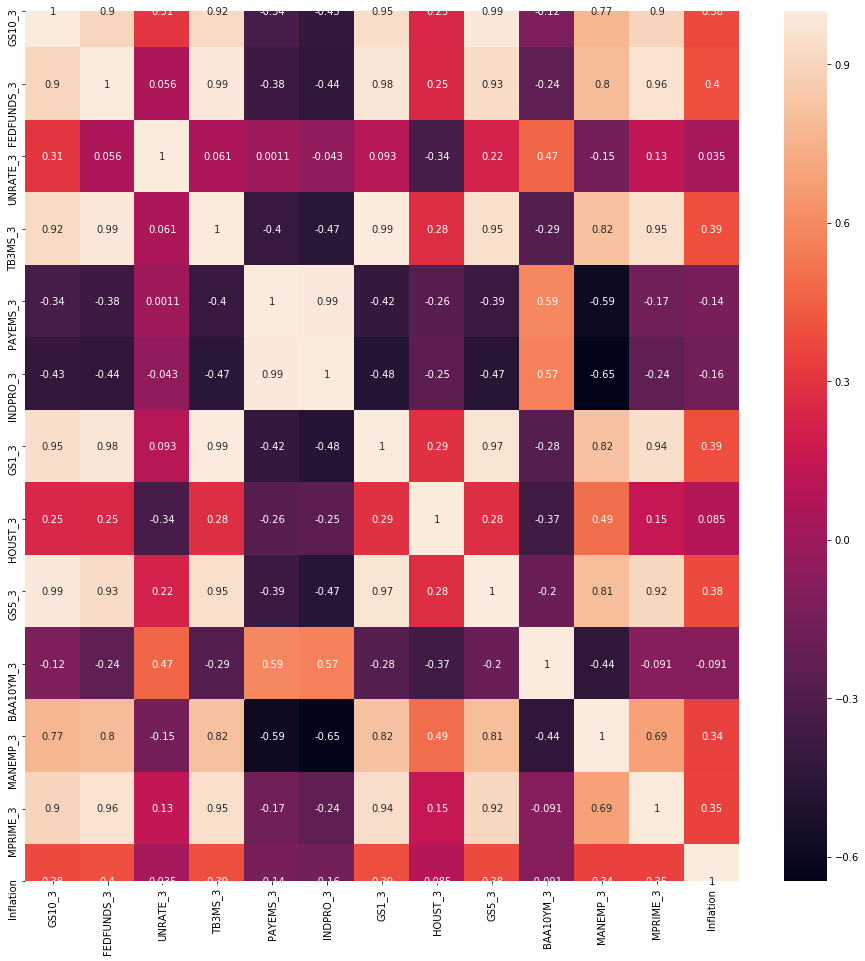

In [0]:
'''
We can visualize using the correlation matrix to get some speculation
'''
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
corr = df.corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr,annot = True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
min_max_scaler = MinMaxScaler()
x = df[df.columns[:-1]]
y = df[df.columns[-1]].values
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2,shuffle=False)
xtrain = min_max_scaler.fit_transform(xtrain)
xtest = min_max_scaler.transform(xtest)

In [0]:
import statsmodels.api as sm
model = sm.OLS(ytrain, xtrain).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.669
Model:                            OLS   Adj. R-squared (uncentered):              0.662
Method:                 Least Squares   F-statistic:                              96.08
Date:                Fri, 22 Nov 2019   Prob (F-statistic):                   2.20e-128
Time:                        01:15:17   Log-Likelihood:                         -334.80
No. Observations:                 583   AIC:                                      693.6
Df Residuals:                     571   BIC:                                      746.0
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.0145      1.123      4.464      0.000       2.808       7.221
x2             2.0057      0.740      2.711      0.007       0.553       3.459
x3             0.1794      0.173      1.039      0.299      -0.160       0.519
x4             0.0116      1.186      0.010      0.992      -2.319       2.342
x5            -1.8638      0.601     -3.103      0.002      -3.044      -0.684
x6             2.5547      0.672      3.803      0.000       1.235       3.874
x7             2.9532      1.630      1.812      0.071      -0.249       6.155
x8            -0.4281      0.132     -3.241      0.001      -0.688      -0.169
x9            -6.3512      1.886     -3.367      0.001     -10.056      -2.646
x10           -0.0341      0.160     -0.213      0.832      -0.349       0.281
x11            0.5086      0.136      3.741      0.000       0.242       0.776
x12           -3.0655      0.554     -5.532      0.000      -4.154      -1.977
==============================================================================
Omnibus:                      132.462   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.508
Skew:                          -0.041   Prob(JB):                     2.89e-06
Kurtosis:                       1.979   Cond. No.                         202.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
predictions = abs(model.predict(xtest).round())
print(confusion_matrix(ytest, predictions))
print(classification_report(ytest, predictions))
accuracy = str(np.mean((predictions == ytest) * 100))
print('\nTesting Accuracy: ' + accuracy)
print('===============================')

[[79 18]
 [30 19]]
              precision    recall  f1-score   support

         0.0       0.72      0.81      0.77        97
         1.0       0.51      0.39      0.44        49

    accuracy                           0.67       146
   macro avg       0.62      0.60      0.60       146
weighted avg       0.65      0.67      0.66       146


Testing Accuracy: 67.12328767123287


In [0]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
for ker in ['linear','poly','rbf','sigmoid']:
  regressor = SVC(kernel=ker)
  regressor.fit(xtrain,ytrain)
  pred_train = regressor.predict(xtrain)
  pred = regressor.predict(xtest)
  print('Kernel:',ker)
  print(confusion_matrix(ytest, pred))
  print(classification_report(ytest, pred))
  accuracy = str(np.mean((pred == ytest) * 100))
  print('\nTesting Accuracy: ' + accuracy)
  print('===============================')

Kernel: linear
[[97  0]
 [49  0]]
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.80        97
         1.0       0.00      0.00      0.00        49

    accuracy                           0.66       146
   macro avg       0.33      0.50      0.40       146
weighted avg       0.44      0.66      0.53       146


Testing Accuracy: 66.43835616438356
Kernel: poly
[[ 0 97]
 [ 0 49]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        97
         1.0       0.34      1.00      0.50        49

    accuracy                           0.34       146
   macro avg       0.17      0.50      0.25       146
weighted avg       0.11      0.34      0.17       146


Testing Accuracy: 33.56164383561644
Kernel: rbf
[[97  0]
 [49  0]]
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.80        97
         1.0       0.00      0.00      0.00        49

    accurac

In [0]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(xtrain,ytrain)
#Predict the response for test dataset
pred = clf.predict(xtest)
pred_train = clf.predict(xtrain)
print(confusion_matrix(ytest, pred))
print(classification_report(ytest, pred))
accuracy = str(np.mean((pred == ytest) * 100))
print('\nTesting Accuracy: ' + accuracy)
print('===============================')

[[86 11]
 [43  6]]
              precision    recall  f1-score   support

         0.0       0.67      0.89      0.76        97
         1.0       0.35      0.12      0.18        49

    accuracy                           0.63       146
   macro avg       0.51      0.50      0.47       146
weighted avg       0.56      0.63      0.57       146


Testing Accuracy: 63.013698630136986


In [0]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from keras.optimizers import Adam
from datetime import datetime
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
input_dim = len(xtrain[0])
output_dim = 1
layers = 3

logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10) 
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=logdir)

model = Sequential()
model.add(Dropout(0.2, input_shape=(input_dim,))) # dropout regularization
model.add(Dense(5, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, input_dim=input_dim, activation='relu'))
model.add(Dense(output_dim, activation='sigmoid'))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
print(model.summary())
history = model.fit(xtrain, ytrain, epochs=2000,batch_size=20, verbose=0,validation_split=0.1)
#history = model.fit(xtrain, ytrain, epochs=100, batch_size=20, verbose=0, validation_split=0.2, callbacks=[early_stopping_cb, tensorboard_cb]) # Use this line if want to try Tensorboard

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_13 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 65        
_________________________________________________________________
dropout_14 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 4         
Total params: 87
Trainable params: 87
Non-trainable params: 0
_________________________________________________________________
None


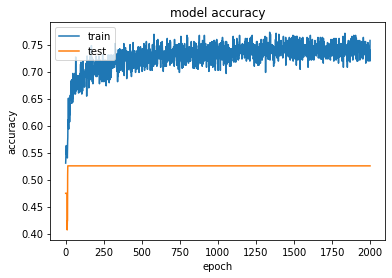

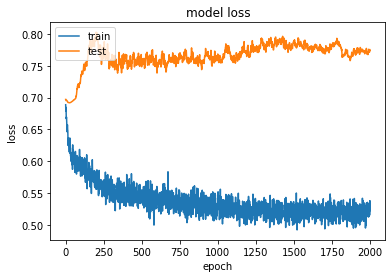

In [0]:
# plotting history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plotting history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(0, 1)

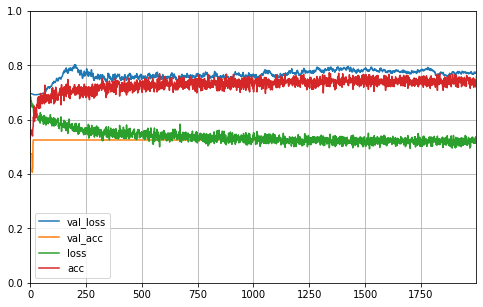

In [0]:
#Another way of viewing loss/accuracy using pandas
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True) 
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()

In [0]:
print('Loss and accurary of test set', model.evaluate(xtest, ytest))
y_test_pred = model.predict(xtest)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix = confusion_matrix(ytest, y_test_pred.round())
print(confusion_matrix)
print(classification_report(ytest, y_test_pred.round()))
accuracy = str(np.mean((pred == ytest) * 100))
print('\nTesting Accuracy: ' + accuracy)
print('===============================')

146/146 [==============================] - 0s 99us/step
Loss and accurary of test set [0.6477234437041086, 0.6643835600108317]
[[97  0]
 [49  0]]
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.80        97
         1.0       0.00      0.00      0.00        49

    accuracy                           0.66       146
   macro avg       0.33      0.50      0.40       146
weighted avg       0.44      0.66      0.53       146


Testing Accuracy: 63.013698630136986


## 2. Comparision between models

Model|Linear Regression | SVC_linear | SVC_poly | SVC_rbf |SVC_sigmoid | DecisionTree | NeuralNet
--- | ---| ---| ---| ---| ---| ---| ---
**Test Accurary(%)** | 67.123 | 66.438 | 33.562 | 66.438 | 66.438 | 63.014| 63.014

From the result above, we see that a simple linear regression model can outperform other advanced statistics and machine learning model. This leads into a conclusion that we use model depends on what kind of data we have. As of for inflation prediction, we have limited number of features, so forcing an advanced model is overkill and the model would be overfit. 


# III. Conclusion
Forecasting macroeconomics indicators has always been a challenging problem especially predicting GDP. In this project, we reduce the problem to a simple classification to determine whether the U.S. economy would be stable or not instead of predicting the actual growth value. Thus, we are able to achieve a reasonable test result of about 65%. We use various classical and advanced machine learning methods and compare them against each other. It is shown that the results are reletively similar, and advance machine learning methods are not required for such project yet. The main reason is that the data is not complex enough to require the need of neural network model, and sometimes, even a simple linear regression would perform best.


**Future Research**

Unlike other machine learning applications where the more features, the better. Time series model would require a more careful features selections. This project, we carefully picked a dozen of features that we believe to have an impact of GDP and inflation rate. Future research can be focus on:

1. Get more useful features
2. Use news and run NPL model
3. Fine-tune existing models